# Testing Loiter Attack with Overt and Subtle approach
This notebook looks at detecting GPS spoofing during loiter with the overt
and subtle approaches. Ideally the subtle approach would showcase how
the method can be used to detect spoofing by comparing the GPS Ground Course to
the Optical Flow or the Gyroscope.

The data files can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.

## Multi-Step, 1m/s/s, 2m offset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "multistep_loiter_2m.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output, SNS_COUNT=4)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(276709434, unit='us')
attack_end = pd.to_datetime(285000000, unit='us')
benign_dist = 7.348
benign_angle = 14
figure = 1

In [2]:
from confirmation.process import geodetic2ned, body_to_earth2D, low_pass_filter, signal_match_and_cumsum, change_in_signal, diff
import matplotlib.pyplot as plt
from matplotlib import dates
from scipy.integrate import trapezoid
plt.ion()

gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

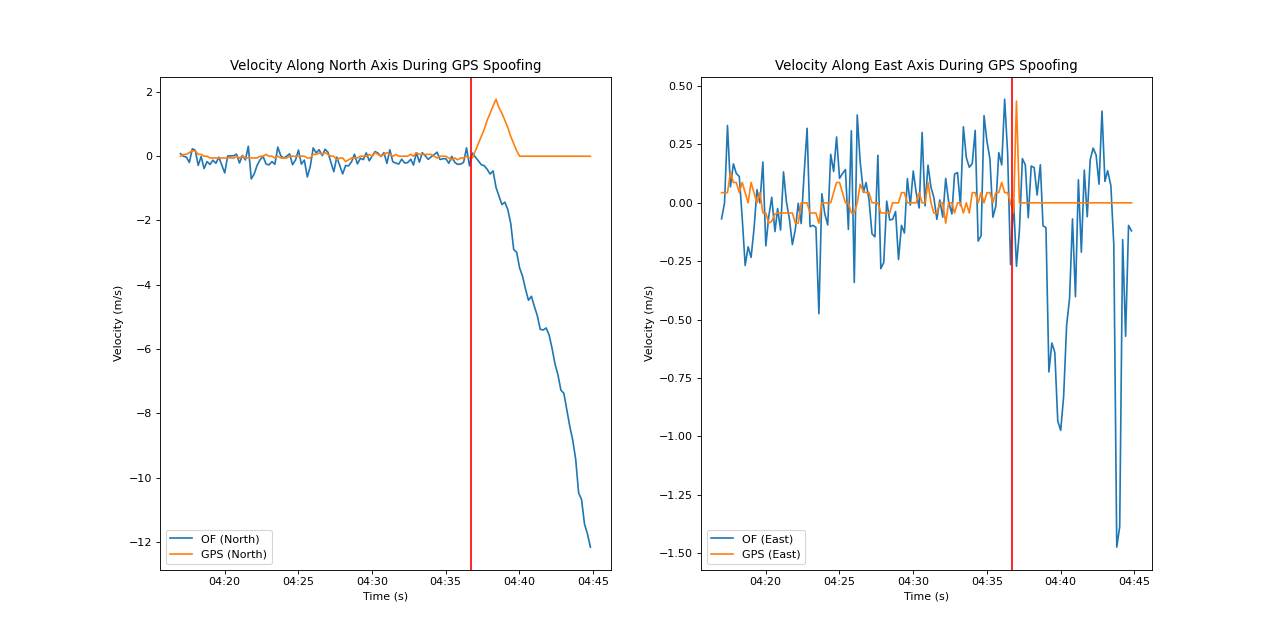

In [3]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_east[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

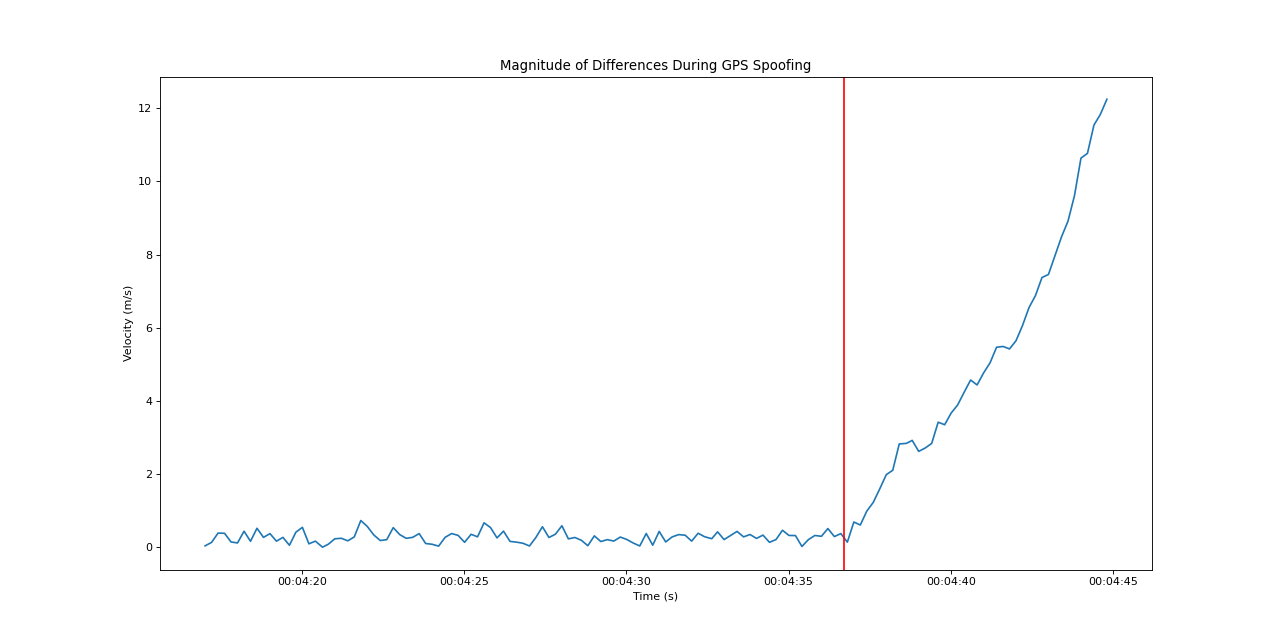

In [4]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
diff_east = abs((gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()])
diff_north = abs((gps_north - of_north)[:(gpsMS.gpsMS < attack_end).sum()])
diffs = pd.Series([((x**2) + (y**2))**(1/2) for x,y in zip(diff_east, diff_north)])
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()],diffs)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Magnitude of Differences During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.show()

In [5]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
       diffs[gpsMS.gpsMS < attack_start].max(),
       diffs[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.735730 m/s and after attack is 12.244780 m/s


In [6]:
dt = (gpsMS.gpsMS[diffs[diffs>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 6.099566s


In [7]:
from confirmation.process import length
OF_Vel_East = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel_North = of_north[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel = length([OF_Vel_East.reset_index(drop=True), OF_Vel_North.reset_index(drop=True)])
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum()))

Distance traveled until detection according to Optical Flow: 17.528857m


## GPS Ground Course and Gyroscope Yaw

In [8]:
#Read in data
df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Only want the part of the attack where the GPS ground course is valid
df = df[df.TimeUS <= 280600000].reset_index(drop=True)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')

In [9]:
from confirmation.process import trap_integrate
from math import degrees, atan2
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

gps_east = pd.Series(gps_east)
gps_north = pd.Series(gps_north)

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the GPS update rate
gyr_heading = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_heading = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum()[2:].reset_index(drop=True), change_in_signal(gyr_heading),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_heading = pd.Series(gyr_gps_heading, name="Gyroscope Heading")

#Start gyroscope at 0 as the initial heading is North
gyr_gps_heading = (gyr_gps_heading - gyr_gps_heading[0])%360

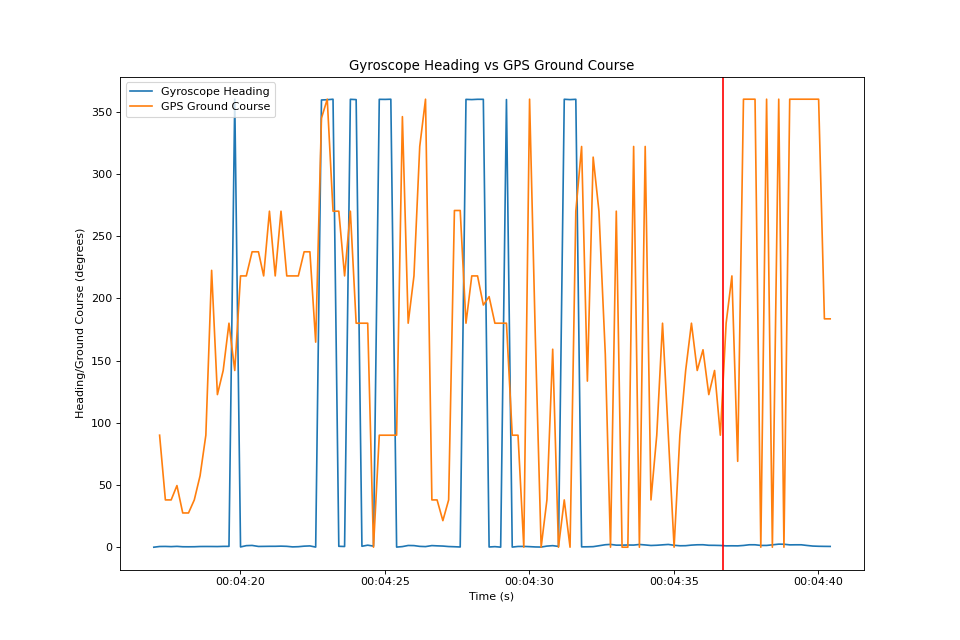

In [10]:
plt.figure(figure, figsize=(12, 8), dpi=80)
figure += 1
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS, gyr_gps_heading, label="Gyroscope Heading")
plt.plot(gpsMS.gpsMS[1:], gps_gc, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Heading/Ground Course (degrees)")
plt.title("Gyroscope Heading vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

In [11]:
angle_diff = abs(diff(gps_gc[1:].reset_index(drop=True), gyr_gps_heading, wrap=True))

print("Difference between GPS and OF before attack is %f degrees and after attack is %f degrees" % (
       angle_diff[gpsMS.gpsMS < attack_start].max(),
       angle_diff[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Difference between GPS and OF before attack is 179.908500 degrees and after attack is 177.417439 degrees


In [12]:
dt = (gpsMS.gpsMS[angle_diff[angle_diff>benign_angle].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: -19.700434s


## One-Step, 2m offset

In [13]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "onestep_loiter_2m.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output, SNS_COUNT=4)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(262690960, unit='us')
attack_end = pd.to_datetime(277000000, unit='us')
benign_dist = 7.348
benign_angle = 14

In [14]:
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

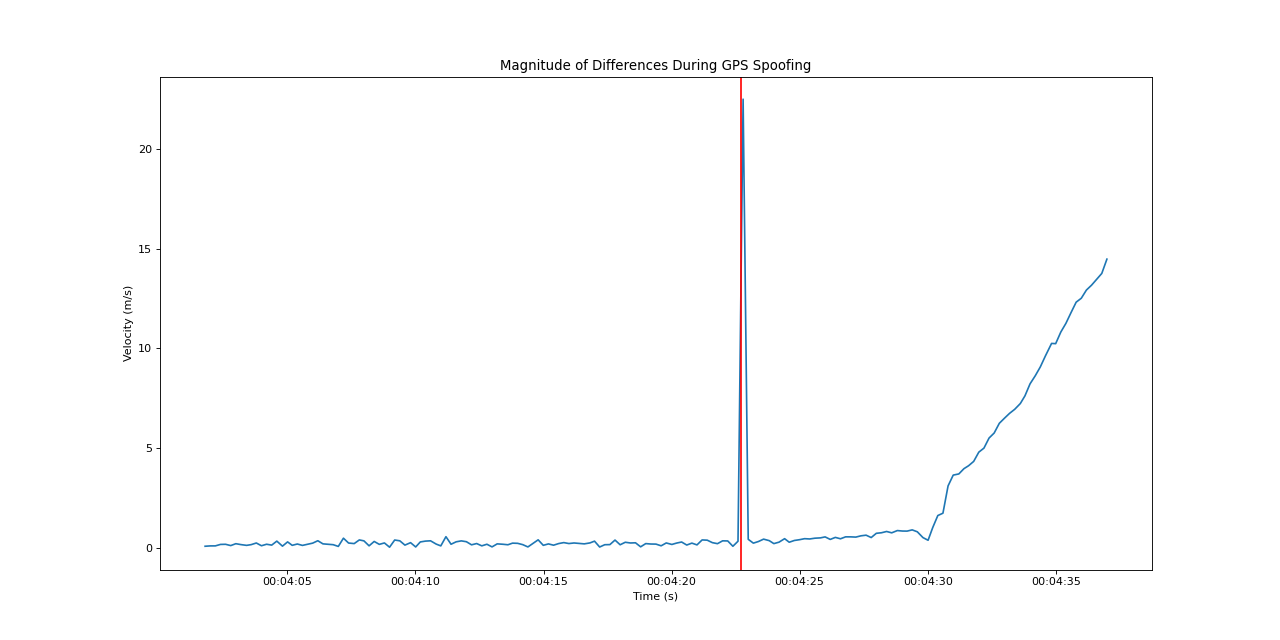

In [15]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
diff_east = abs((gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()])
diff_north = abs((gps_north - of_north)[:(gpsMS.gpsMS < attack_end).sum()])
diffs = pd.Series([((x**2) + (y**2))**(1/2) for x,y in zip(diff_east, diff_north)])
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()],diffs)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Magnitude of Differences During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.show()

In [16]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
       diffs[gpsMS.gpsMS < attack_start].max(),
       diffs[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.550321 m/s and after attack is 22.496409 m/s


In [17]:
dt = (gpsMS.gpsMS[diffs[diffs>benign_dist].index[1]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 11.099040s


In [18]:
from confirmation.process import length
OF_Vel_East = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel_North = of_north[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel = length([OF_Vel_East.reset_index(drop=True), OF_Vel_North.reset_index(drop=True)])
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum()))

Distance traveled until detection according to Optical Flow: 19.574761m


## GPS Ground Course and Gyroscope Yaw

In [19]:
#Read in data
df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Only want the part of the attack where the GPS ground course is valid
df = df[df.TimeUS <= 280600000].reset_index(drop=True)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')

In [20]:
from confirmation.process import trap_integrate
from math import degrees, atan2
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

gps_east = pd.Series(gps_east)
gps_north = pd.Series(gps_north)

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the GPS update rate
gyr_heading = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_heading = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum()[2:].reset_index(drop=True), change_in_signal(gyr_heading),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_heading = pd.Series(gyr_gps_heading, name="Gyroscope Heading")

#Start gyroscope at 0 as the initial heading is North
gyr_gps_heading = (gyr_gps_heading - gyr_gps_heading[0])%360

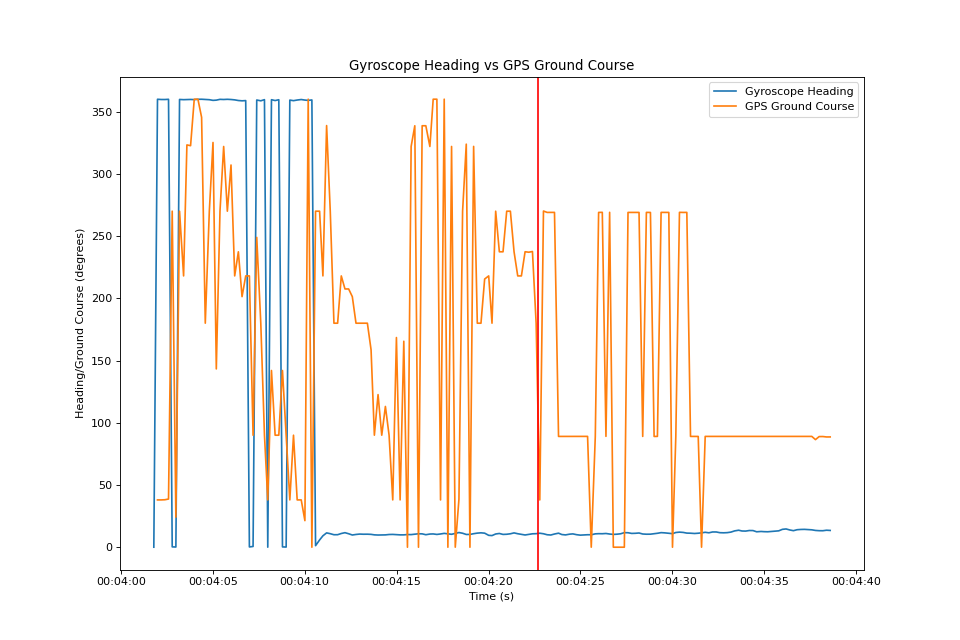

In [21]:
plt.figure(figure, figsize=(12, 8), dpi=80)
figure += 1
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS, gyr_gps_heading, label="Gyroscope Heading")
plt.plot(gpsMS.gpsMS[1:], gps_gc, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Heading/Ground Course (degrees)")
plt.title("Gyroscope Heading vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

In [22]:
angle_diff = abs(diff(gps_gc[1:].reset_index(drop=True), gyr_gps_heading, wrap=True))

print("Difference between GPS and OF before attack is %f degrees and after attack is %f degrees" % (
       angle_diff[gpsMS.gpsMS < attack_start].max(),
       angle_diff[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Difference between GPS and OF before attack is 179.912470 degrees and after attack is 103.068419 degrees
